In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
from math import pi

In [2]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

class makedata(Dataset):
    def __init__(self, col, n_feat, maximum):
        self.col = col  #number of datapoints/columns
        self.n_feat = n_feat  #number of features/rows
        self.maximum = maximum #factor to control range of feature data
        self.classes = 2   #number of classes

        if col%2 != 0:
            col = col+1
            print("Making datasize an even number for ease: col =", col)
            
        self.Xdata1 = torch.rand(col//2, n_feat)*maximum -0.4 
        self.Xdata2 = torch.rand(col//2, n_feat)*(-maximum) +0.4
        self.Xdata = torch.cat((self.Xdata1, self.Xdata2), dim=0)

        self.Ydata = torch.cat((torch.full((col//2,), 1),torch.full((col//2,), -1)))       

    def __len__(self):
        return len(self.Ydata)

    def __getitem__(self, idx):
        return self.Xdata[idx],self.Ydata[idx]


In [52]:
r =5
data = makedata(1000, 2, r)

In [53]:
print(len(data))
print(data.Xdata1)
print(data.Xdata2)

print(data.Ydata)

1000
tensor([[ 4.4105e-01,  2.4126e+00],
        [ 3.9656e+00,  3.9111e+00],
        [ 3.6531e+00,  2.9070e-01],
        [ 2.9974e-01,  5.8807e-01],
        [ 2.4141e+00,  4.5917e+00],
        [ 5.2081e-01,  3.4322e+00],
        [ 7.1628e-01, -2.5054e-01],
        [ 1.5687e+00,  3.5404e+00],
        [ 4.4209e+00,  5.4740e-01],
        [ 2.6425e+00,  4.2572e+00],
        [ 3.7566e+00,  3.6581e+00],
        [ 3.8766e+00,  3.6813e+00],
        [ 2.7457e+00,  3.9045e-01],
        [ 6.0371e-04,  9.5445e-01],
        [ 1.8089e+00,  5.6762e-01],
        [ 3.0146e+00,  2.8737e+00],
        [ 1.5339e+00,  3.0609e+00],
        [ 2.9080e+00,  3.6263e+00],
        [ 3.7836e+00,  1.2534e+00],
        [ 4.5426e+00,  1.8110e+00],
        [ 2.0141e+00, -2.5970e-01],
        [ 4.9096e-01,  6.3949e-01],
        [ 1.0307e+00,  3.8774e+00],
        [ 1.2830e+00,  2.3180e-01],
        [ 3.0619e+00,  2.9004e+00],
        [ 3.7192e+00,  8.0632e-01],
        [ 2.6420e+00,  1.1899e+00],
        [ 1.5383e+00,  

In [54]:
x,y = data.__getitem__(2)
print(x,y)

tensor([3.6531, 0.2907]) tensor(1.)


In [55]:
np_Xdata1 = data.Xdata1.detach().numpy()
np_Xdata2 = data.Xdata2.detach().numpy()

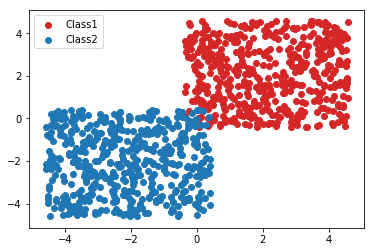

In [56]:
import matplotlib.pyplot as plt

colors = ("red", "blue")
groups = ("class 1", "class 2")

plt.scatter(np_Xdata1[:,0], np_Xdata1[:,1], color="tab:red", label= "Class1")
plt.scatter(np_Xdata2[:,0], np_Xdata2[:,1], color="tab:blue", label = "Class2")
plt.legend(loc = 'best')
plt.show()

In [57]:
batch_size = 32
data_batches = DataLoader(data, batch_size=batch_size, shuffle=True)
for d in data_batches:
    x,y = d
    print(x,y)
    break
x.shape[0]

tensor([[ 1.1784,  3.1433],
        [-2.7950, -1.0225],
        [-1.0575, -3.6334],
        [-2.5093, -4.3786],
        [-3.2363, -0.3096],
        [ 0.0679, -0.3996],
        [-3.7574, -2.0536],
        [-3.2681, -2.4132],
        [ 0.8877,  1.6228],
        [-4.5320, -2.2023],
        [-3.6674, -4.3165],
        [-4.5783, -2.3754],
        [-0.0404, -0.3509],
        [ 4.3356,  1.6971],
        [ 1.4550,  2.0645],
        [ 0.2590, -2.6480],
        [-4.3789,  0.1235],
        [-3.0306, -0.8171],
        [-3.5084, -2.2441],
        [-1.9226, -0.5998],
        [ 1.7909,  1.4998],
        [ 0.5633,  0.9330],
        [-1.9494, -2.9236],
        [-1.3081, -2.6265],
        [-4.3133,  0.2400],
        [ 0.0344,  1.2974],
        [-1.5714, -0.7328],
        [ 1.0446, -0.0664],
        [ 3.7432,  3.6668],
        [ 2.6420,  1.1899],
        [ 0.1976, -1.5409],
        [-2.7858, -1.5798]]) tensor([ 1., -1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
         1., -1., -1., -1

32

In [142]:
for l in x:
    print(l)

tensor([6.0371e-04, 9.5445e-01])
tensor([-2.8117, -2.6727])
tensor([3.4356, 4.4186])
tensor([0.6752, 4.0191])
tensor([1.0289, 0.5777])
tensor([1.8805, 1.2669])
tensor([-0.7401, -2.0784])
tensor([3.1547, 3.5146])
tensor([0.7885, 0.1331])
tensor([-4.0133,  0.0084])
tensor([-0.5552, -2.1327])
tensor([1.8139, 1.9678])
tensor([0.4516, 0.7467])
tensor([-1.5284,  0.0293])
tensor([3.1691, 2.5567])
tensor([-1.2578, -0.5333])
tensor([ 3.6567, -0.3376])
tensor([-4.1270, -4.0254])
tensor([4.3193, 3.7915])
tensor([2.7955, 2.6511])
tensor([3.9187, 4.0802])
tensor([1.2965, 3.1099])
tensor([-1.7898, -0.8210])
tensor([0.2663, 3.1134])
tensor([-1.4629, -3.7510])
tensor([0.9474, 2.4010])
tensor([1.1224, 0.0408])
tensor([-1.1153, -3.6760])
tensor([1.5097, 0.3506])
tensor([2.3571, 3.8243])
tensor([4.3043, 0.1959])
tensor([-2.5138, -0.7034])


In [128]:
from pennylane.templates.embeddings import AmplitudeEmbedding

def randlayer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0,1])

dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev, interface = 'torch')
def circuit(w1, w2, p=None):
    AmplitudeEmbedding(p, wires=[0,1], pad=True, normalize=True)
    randlayer(w1)
    randlayer(w2)
    return qml.expval(qml.PauliZ(0))


In [129]:
def get_pred(w1, w2, x):   #predictions for one batch
    batch_size = x.shape[0]
    
    torch.clamp(input, min, max, out=None)
    pred_batch = torch.empty(batch_size,)    
    for i in range(batch_size):
        pred = circuit(w1, w2, p=x[i])
        if pred > 0:
            pred = torch.tensor([1])
        elif pred < 0:
            pred = torch.tensor([-1])
        elif pred == 0:
            random = np.rand(1, )
            if random > 0.5:
                pred = torch.tensor([1])
            elif random < 0.5:
                pred = torch.tensor([-1])
                
        print(pred)

        print("GRAD: ", pred.grad)
        print("GRAD: ", pred.requires_grad)
        pred_batch[i] = pred
        
    return pred_batch

In [130]:
def get_loss(w1, w2, x, y):
    loss = 0
    pred = get_pred(w1, w2, x)
    print(pred.requires_grad)
    for p, label in zip(pred, y):
        if torch.abs(label - p) < 1e-5:
            loss = loss + 1
    return loss /len(y)

In [131]:
torch.manual_seed(1)
w1_init = Variable(2*pi * torch.rand(2, 3), requires_grad=True)
w2_init = Variable(2*pi * torch.rand(2, 3), requires_grad=True)

print(w1_init.requires_grad)

True


In [132]:
#test = Variable(torch.tensor([1, 20.5]),requires_grad = True)
#res = circuit(w1_init, w2_init, p=test)
#print(res)

In [133]:
#res.backward()
#w1_init.grad

In [134]:
w1= w1_init
w2= w2_init
print(w1.requires_grad)

True


In [135]:
opt = torch.optim.Adam([w1_init, w2_init], lr = 0.01)
rec= []
    
for d in data_batches:
#for step in range(100):
    x,y = d
    opt.zero_grad()
    loss = get_loss(w1_init, w2_init, x, y)
    loss.backward()
    opt.step()
    rec.append(loss.item())
    print(loss)
    print(w1_init)
    print(w1_init.grad)

tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GRAD:  None
GRAD:  False
tensor([-1])
GR

AttributeError: 'float' object has no attribute 'backward'

In [ ]:
rec

In [ ]:
fin1, fin2 = opt.param_groups[0]['params']
print(fin1)

In [ ]:
with torch.no_grad():
    x,y = data.__getitem__(2)    
    pred = get_pred(fin1,fin2,x)
    print(pred, y)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    
    def __init__(self):
        super(Classifier, self).__init__()
        self.w1_init = Variable(2*pi * torch.rand(2, 3), requires_grad=True)
        self.w2_init = Variable(2*pi * torch.rand(2, 3), requires_grad=True)
        
    def forward(self, w1, w2, x):  #what to do with data in these layers
        @qml.qnode(dev, interface = 'torch')
        def circuit(w1, w2, p=None):
            AmplitudeEmbedding(p, wires=[0,1], pad=True, normalize=True)
            randlayer(w1)
            randlayer(w2)
            return qml.expval(qml.PauliZ(0))
        pred = circuit(w1, w2, p=x)
        if pred > 0:
            return torch.ceil(pred)
        elif pred < 0:
            return torch.floor(pred)
    

In [ ]:
test_cl = Classifier()
print(test_cl.w1_init)

In [ ]:
out = test_classifier(test)
out = out.view(1,)
print(out.view(1,))
target = Variable(torch.tensor([1], dtype=torch.float64),requires_grad = True)
print(target)

In [ ]:
loss = F.mse_loss(out, target)
print(loss)

In [ ]:
opt = torch.optim.Adam([test_cl.w1_init,test_cl.w2_init], lr = 0.01)

for epoch in range(3):
    for d in data_batches:
        x,y = d
        opt.zero_grad()
        out = test_classifier(x)
        out = out.view(1,)
        loss = F.mse_loss(out, y)
        loss.backward()
        opt.step()
    print(loss)

In [ ]:
tp = torch.tensor([1.0, 1.0])
ty= torch.tensor([-1.0, 1.0])
print(torch.sum((tp-ty)**2))

In [ ]:
t1 = Variable((2*pi * torch.rand((5, ), dtype=torch.float64)), requires_grad=True)
t2 = Variable((2*pi * torch.rand((5, ), dtype=torch.float64)), requires_grad=True)

In [ ]:
t1

In [ ]:
t1-t2

In [ ]:
(t1-t2)**2

In [ ]:
torch.sum((t1-t2)**2) / len(t1)

In [ ]:
temp = Variable(torch.zeros(1,), requires_grad=True)
temp = temp + 1
temp

In [22]:
torch.rand(2, 3)

tensor([[0.3398, 0.5239, 0.7981],
        [0.7718, 0.0112, 0.8100]])

In [140]:
print(torch.tensor([-11]) > -2)


tensor([False])
